Note: Running every cell takes upwards to 15 minutes

In [ ]:
!pip install kora
!pip install requests-html
from requests_html import HTMLSession
from time import sleep
from bs4 import BeautifulSoup
from kora.selenium import wd
from scipy.stats import pearsonr
import requests
import pandas as pd
import seaborn as sb

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 92kB 3.3MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 143kB 6.4MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp37-none-any.whl size=13485 sha256=7c98563b24118fe41269673447fa4b1587f9db73b8d3efb724a027624dc3cce2
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for parse: filename=parse-1.19.0-cp37-none-any.whl size=24581 sha256=5eebc7114ef453e24f6d6f8fe9cd7f644eaa49c72eba3f8673d916f76ea5f239
  Stored in directory: /root/.cache/pip/wheels/c0/39/ea/e2fd678bd130953f5438470b8dfa529f00787e9b8b92b27467
Successfully built fake-useragent parse
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


#**The Final 6 Months of President Trump's Tweets**
By Jack Doughty

# The Data:
Former President Donald Trump's Twitter had been a source of controversy for Americans for the entirety of his presidency. Diving into the intriguing yet controversial data of his former Twitter account may yeild interesting trends as to what eventually led to his suspension from the platform. The data was scraped from a Trump twitter archive via several python libraries including BeautifulSoup and requests_HTML. 5000 tweets with the text, date, time, likes, retweets, and whether it was taken down or not were all collected.

The archive: https://www.thetrumparchive.com/

# Scrape Data

From https://www.thetrumparchive.com/ 5000 tweets were collected. Because the website implements infinite scrolling the HTML only contains 20 tweets upon loading the site. Thus, BeautifulSoup was insufficient in collecting a large number of data. A webdriver was used to load the site and an HTMLSession was used to scroll 200 pages down, making the website call 5000 tweets via its API.

In [ ]:
#Creates HTMLSession object
session = HTMLSession()
#Opens website on webdriver
wd.get("https://www.thetrumparchive.com/")

#Web driver scrolls 200 pages to load 4000 tweets
for i in range(0, 200):
  #Webdriver executes this script to scroll
  wd.execute_script('window.scrollTo(0, document.body.scrollHeight)')
  #Prevents webdriver from overloading the sites API with too many requests
  sleep(1)

#BeautifulSoup organizes the HTML gathered by the webdriver
tweets_raw = session.get("https://www.thetrumparchive.com/")
tweets_soup = BeautifulSoup(wd.page_source)

#Find all tweets in the HTML document
trump_tweets_soup = tweets_soup.find_all('div', {'class' : "tweet___2xXtA ttaTweet"})
#Print first 5 tweets
for i in range(5):
  print(trump_tweets_soup[i].text)

1.Jan 8th 2021 - 10:44:28 AM ESTJan 8 2021 - 10:44am 84k 511k ShowTo all of those who have asked, I will not be going to the Inauguration on January 20th.
2.Jan 8th 2021 - 9:46:38 AM ESTJan 8 2021 - 9:46am 109k 481k ShowThe 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT AGAIN, will have a GIANT VOICE long into the future. They will not be disrespected or treated unfairly in any way, shape or form!!!
3.Jan 7th 2021 - 7:10:24 PM ESTJan 7 2021 - 7:10pm 155k 629k Showhttps://t.co/csX07ZVWGe
4.Jan 6th 2021 - 6:01:04 PM ESTJan 6 2021 - 6:01pm 0 0 DeletedThese are the things and events that happen when a sacred landslide election victory is so unceremoniously & viciously stripped away from great patriots who have been badly & unfairly treated for so long. Go home with love & in peace. Remember this day forever!
5.Jan 6th 2021 - 4:17:24 PM ESTJan 6 2021 - 4:17pm 0 0 Deletedhttps://t.co/Pm2PKV0Fp3


Now that the data is gathered from the archive it needs to be formatted in a panda's dataframe for easy observation and manipulation. To do this, each tweet is split up into seperate pieces of data. Because the data is in the same format for each Tweet, they are easily pulled apart and added to corresponding lists which are then turned into rows.

In [ ]:
tweet_dict = []

#Loops through each Tweet
for tweet in trump_tweets_soup:
  #Splits the Tweet up (except the text).
  tweet_split = tweet.text.split(" ", 13)
  #The month is concatenate with the tweet number. This splits it.
  month = tweet_split[0]
  day = tweet_split[1]
  year = tweet_split[2]
  time = tweet_split[10]
  retweets = tweet_split[11]
  likes = tweet_split[12]
  text = tweet_split[13]
  tweet_dict_payload = {'Month' : month, 'Day' : day ,'Year' : year, 'Time' : time, 'Retweets' : retweets, 'Likes' : likes, 'Text' : text}
  tweet_dict.append(tweet_dict_payload)
#Adds Tweet data into a row in the dataframe
df = pd.DataFrame(tweet_dict)
df.head()

,Month,Day,Year,Time,Retweets,Likes,Text
0,1.Jan,8th,2021,10:44am,84k,511k,"ShowTo all of those who have asked, I will not..."
1,2.Jan,8th,2021,9:46am,109k,481k,"ShowThe 75,000,000 great American Patriots who..."
2,3.Jan,7th,2021,7:10pm,155k,629k,Showhttps://t.co/csX07ZVWGe
3,4.Jan,6th,2021,6:01pm,0,0,DeletedThese are the things and events that ha...
4,5.Jan,6th,2021,4:17pm,0,0,Deletedhttps://t.co/Pm2PKV0Fp3


# Clean Data

Now that the data is placed in a dataframe, the data most be thoroughly cleaned. The data must be recasted into different data types, organized, renamed, and filtered.

First off, the month data has numbers concatenated to it. These numbers are removed and the months are placed back in the frame.

In [ ]:
new_month_column = []

for month in df["Month"]:
  month_only = month.split(".")
  new_month_column.append(month_only[1])

df["Month"] = new_month_column
df.head()

,Month,Day,Year,Time,Retweets,Likes,Text
0,Jan,8th,2021,10:44am,84k,511k,"ShowTo all of those who have asked, I will not..."
1,Jan,8th,2021,9:46am,109k,481k,"ShowThe 75,000,000 great American Patriots who..."
2,Jan,7th,2021,7:10pm,155k,629k,Showhttps://t.co/csX07ZVWGe
3,Jan,6th,2021,6:01pm,0,0,DeletedThese are the things and events that ha...
4,Jan,6th,2021,4:17pm,0,0,Deletedhttps://t.co/Pm2PKV0Fp3


If a tweet has 0 retweets, it means the tweet was either removed by Twitter or Trump. Each tweet is looped through and if it has 0 retweets, then the value for that row in the new column "Status" is "deleted." Otherwise it is labled as visible.   

In [ ]:
#Add "deleted" column
deleted_retweets_list = []

for retweets in df["Retweets"]:
  if(retweets == "0"):
     deleted_retweets_list.append("deleted")
  else:
    deleted_retweets_list.append("visible")

df["Status"] = deleted_retweets_list
df.head()

,Month,Day,Year,Time,Retweets,Likes,Text,Status
0,Jan,8th,2021,10:44am,84k,511k,"ShowTo all of those who have asked, I will not...",visible
1,Jan,8th,2021,9:46am,109k,481k,"ShowThe 75,000,000 great American Patriots who...",visible
2,Jan,7th,2021,7:10pm,155k,629k,Showhttps://t.co/csX07ZVWGe,visible
3,Jan,6th,2021,6:01pm,0,0,DeletedThese are the things and events that ha...,deleted
4,Jan,6th,2021,4:17pm,0,0,Deletedhttps://t.co/Pm2PKV0Fp3,deleted


Next, the text has "show" or "Deleted" attached to the front. These values where removed from the text.


In [ ]:
text_filtered1 = []
text_filtered2 = []
#Remove "Show" from beginning of each text
for text in df["Text"]:
  text_only = text.split("how", 1)
  if(len(text_only) > 1):
    text_filtered1.append(text_only[1])
  else:
    text_filtered1.append(text)

#Remove "Deleted" from beginning of each text
for text in text_filtered1:
  text_only = text.split("eleted", 1)
  if(len(text_only) > 1):
    text_filtered2.append(text_only[1])
  else:
    text_filtered2.append(text)
df["Text"] = text_filtered2
df.head()

,Month,Day,Year,Time,Retweets,Likes,Text,Status
0,Jan,8th,2021,10:44am,84k,511k,"To all of those who have asked, I will not be ...",visible
1,Jan,8th,2021,9:46am,109k,481k,"The 75,000,000 great American Patriots who vot...",visible
2,Jan,7th,2021,7:10pm,155k,629k,https://t.co/csX07ZVWGe,visible
3,Jan,6th,2021,6:01pm,0,0,These are the things and events that happen wh...,deleted
4,Jan,6th,2021,4:17pm,0,0,https://t.co/Pm2PKV0Fp3,deleted


Now the columns are reindexed to make the data more organized.

In [ ]:
column_titles = ["Month", "Day", "Year", "Time", "Retweets", "Likes", "Status", "Text"]
df = df.reindex(columns = column_titles)
df.head()

,Month,Day,Year,Time,Retweets,Likes,Status,Text
0,Jan,8th,2021,10:44am,84k,511k,visible,"To all of those who have asked, I will not be ..."
1,Jan,8th,2021,9:46am,109k,481k,visible,"The 75,000,000 great American Patriots who vot..."
2,Jan,7th,2021,7:10pm,155k,629k,visible,https://t.co/csX07ZVWGe
3,Jan,6th,2021,6:01pm,0,0,deleted,These are the things and events that happen wh...
4,Jan,6th,2021,4:17pm,0,0,deleted,https://t.co/Pm2PKV0Fp3


The "Year" data is held as strings so it is recasted as integers.

In [ ]:
int_year_dict = []

for year in df["Year"]:
  int_year_dict.append(int(year))
df["Year"] = int_year_dict

Lastly, the values for "retweets" and "likes" are strings with a "k" attached. The k is removed and the values are multiplied by 1000 if there was a k attached. These new values are then placed into the frame.

In [ ]:
retweets_int_dict = []
likes_int_dict = []

for retweet in df["Retweets"]:
  retweets_split = retweet.split("k")
  retweet_int = int(retweets_split[0]) * 1000
  retweets_int_dict.append(retweet_int)


for like in df["Likes"]:
  like_split = like.split("k")
  like_int = int(like_split[0]) * 1000
  likes_int_dict.append(like_int)

df["Likes"] = likes_int_dict
df["Retweets"] = retweets_int_dict

df

,Month,Day,Year,Time,Retweets,Likes,Status,Text
0,Jan,8th,2021,10:44am,84000,511000,visible,"To all of those who have asked, I will not be ..."
1,Jan,8th,2021,9:46am,109000,481000,visible,"The 75,000,000 great American Patriots who vot..."
2,Jan,7th,2021,7:10pm,155000,629000,visible,https://t.co/csX07ZVWGe
3,Jan,6th,2021,6:01pm,0,0,deleted,These are the things and events that happen wh...
4,Jan,6th,2021,4:17pm,0,0,deleted,https://t.co/Pm2PKV0Fp3
...,...,...,...,...,...,...,...,...
4995,Aug,18th,2020,9:43pm,8000,0,visible,RT @EricTrump: If you want to help @realDonald...
4996,Aug,18th,2020,9:43pm,5000,0,visible,RT @WhiteHouse: President @realDonaldTrump's t...
4997,Aug,18th,2020,9:42pm,5000,0,visible,RT @WhiteHouse: President @realDonaldTrump is ...
4998,Aug,18th,2020,9:42pm,6000,0,visible,RT @TeamTrump: President @realDonaldTrump is i...


Now, we have a dataset with useful, straightforward values for effective data interviewing.

## 1.) Formulate a Question
Does the chance of Donald Trump's tweets being removed or censored increase the later in the night the post is tweeted?

## 2.) Read in the Data
The data has already been scraped and cleaned. The data was scraped from here:
https://www.thetrumparchive.com/?results=1

##3.) Check the Packaging

In [ ]:
df.shape

(5000, 8)

## 4.) Show Top and Bottom of Data

In [ ]:
df.head()

,Month,Day,Year,Time,Retweets,Likes,Status,Text
0,Jan,8th,2021,10:44am,84000,511000,visible,"To all of those who have asked, I will not be ..."
1,Jan,8th,2021,9:46am,109000,481000,visible,"The 75,000,000 great American Patriots who vot..."
2,Jan,7th,2021,7:10pm,155000,629000,visible,https://t.co/csX07ZVWGe
3,Jan,6th,2021,6:01pm,0,0,deleted,These are the things and events that happen wh...
4,Jan,6th,2021,4:17pm,0,0,deleted,https://t.co/Pm2PKV0Fp3


In [ ]:
df.tail()

,Month,Day,Year,Time,Retweets,Likes,Status,Text
4995,Aug,18th,2020,9:43pm,8000,0,visible,RT @EricTrump: If you want to help @realDonald...
4996,Aug,18th,2020,9:43pm,5000,0,visible,RT @WhiteHouse: President @realDonaldTrump's t...
4997,Aug,18th,2020,9:42pm,5000,0,visible,RT @WhiteHouse: President @realDonaldTrump is ...
4998,Aug,18th,2020,9:42pm,6000,0,visible,RT @TeamTrump: President @realDonaldTrump is i...
4999,Aug,18th,2020,9:42pm,6000,0,visible,RT @WhiteHouse: As America celebrates the 100t...


## 5.) Check the "n"'s

**Month:** The month when the tweet was posted.

**Day:** The day when the tweet was posted.

**Year:** The year when the tweet was posted.

**Time:** The time when the tweet was posted.

**Retweets:** A rounding to the thousanth place of the number of retweets the tweet recieved.

**Likes:** A rounding to the thousanth place of the number of likes the tweet recieved.

**Status:** The status of the tweet as to whether it was taken down or visible to the public at the time of the account being suspended.

**Text:** The written text of the tweet.

Via the .dropna() all elements with missing pieces of data are
removed. However, after calling the .shape method on the dataset there are still 5000 elements showing that every one has 8 points of data.

In [ ]:
#Removes elements with missing points of data.
df.dropna()
df.shape

(5000, 8)

The tweets range from August 2020 to January 2021. Lets make sure no time is outside of this range.

In [ ]:
df.sort_values(by=['Year'], ascending = False).head()

,Month,Day,Year,Time,Retweets,Likes,Status,Text
0,Jan,8th,2021,10:44am,84000,511000,visible,"To all of those who have asked, I will not be ..."
104,Jan,2nd,2021,6:17pm,28000,0,visible,RT @HawleyMO: Glad to see more Senators joinin...
97,Jan,3rd,2021,1:25am,22000,102000,visible,GOP Senators Join Hawley in Objecting to Elect...
98,Jan,3rd,2021,12:35am,31000,99000,visible,https://t.co/moYUIcRq56
99,Jan,3rd,2021,12:09am,37000,145000,visible,https://t.co/JLq7hHI42o


In [ ]:
df.sort_values(by=['Likes']).head()

,Month,Day,Year,Time,Retweets,Likes,Status,Text
4999,Aug,18th,2020,9:42pm,6000,0,visible,RT @WhiteHouse: As America celebrates the 100t...
1807,Oct,30th,2020,12:49pm,4000,0,visible,RT @GOP: Only 4️⃣ days until ELECTION DAY!\n \...
1806,Oct,30th,2020,12:49pm,5000,0,visible,RT @CCarrGOP: Nothing Lil about the biggest gr...
1805,Oct,30th,2020,12:49pm,5000,0,visible,RT @GOP: America is roaring back!\n \nTo conti...
1804,Oct,30th,2020,12:50pm,4000,0,visible,RT @GOP: “But no one believes Biden will stand...


# 6.) Validate against an External Source

The tweets were sorted by most number of likes. Trump's most liked tweet in the dataframe is found below. According to  https://www.tweetbinder.com/blog/trump-twitter/ this is Trump's most liked Tweet of all time certifing that the tweets are real and have accurate data.

In [ ]:
print(df.iloc[3064]['Text'])
df.sort_values(by=['Likes'], ascending = False).head()

Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!


,Month,Day,Year,Time,Retweets,Likes,Status,Text
3064,Oct,2nd,2020,12:54am,409000,1870000,visible,"Tonight, @FLOTUS and I tested positive for COV..."
3062,Oct,2nd,2020,11:31pm,140000,1220000,visible,"Going welI, I think! Thank you to all. LOVE!!!"
1451,Nov,7th,2020,10:36am,191000,1188000,visible,"I WON THIS ELECTION, BY A LOT!"
1394,Nov,10th,2020,8:44am,165000,1024000,visible,WE WILL WIN!
1449,Nov,7th,2020,4:54pm,158000,978000,visible,"71,000,000 Legal Votes. The most EVER for a si..."


# 7.) Make a Plot

Let's visualize the time the tweet was posted vs. whether it was deleted or not. To do this the time will be converted from a string containing "pm" or "am" to a 24 hour scale where the day begins at 5 am instead of 12 am. The start time is changed because Trump's night hours go past 12 am as he tweets past this time. This creates a scale from 1 to 24 with 1 being the earliest part of the day and 24 being the latest. The "Status" values will then be converted to binary values. The average "Status" value per hour will then be found and plotted.

In [ ]:
time_int = []

#Loop through each time value
for time in df["Time"]:
  #This adder converts the time from 12am-12pm range to 1-24 hour range
  adder = 0

  #Splits the time string up into hour and minutes
  time_split = time.split(':')
  hour = int(time_split[0])
  min = time_split[1]
  min_pm = min.split('p')

  #If the time is in 'pm' and less than 12 the adder is set to 12
  if min_pm[len(min_pm) - 1] == 'm':
    if hour < 12:
      adder = 12

  #If the time is in 'am' and equal to 12 adder is set to 12
  if min_pm[len(min_pm) - 1] != 'm':
    if hour == 12:
      adder = 12

  #Hour is added by either 12 or 0 depending on whether it is 'pm' or 'am'
  hour += adder

  #Converts 24 hour scale from starting at 1 am and ending at midnight to starting at 5 am and ending at 4 am
  if hour < 5:
    hour += 20
  if hour >= 5:
    hour -= 4
  #Adds converted time to dictionary
  time_int.append(hour)

#Adds scaled time to new colum in dataframe called "Scalled Time"
df['Scaled Time'] = time_int

Now lets create a dictionary with binary values for "Status."

In [ ]:
status_binary = []
status_val = 0

#Loops through each status in column "Status." If the status is 'deleted' it is stored as 1 and if it is "visible" it is stored as 0.
for status in df["Status"]:
  if status == "deleted":
    status_val = 1
  else:
    status_val = 0
  status_binary.append(status_val)
df["Status"] = status_binary


Now lets find the average "Status" value per hour. The hours will be placed as keys and the probability will be the values in a new dictionary.

In [ ]:
time_status_dict = {}
average = 0
count = 0

#Loops through each rescaled hour (1-24).
for num in range (1, 25):
  #Loops through each row in df.
  for i in range(0, len(df)):
    #If the time in that row is equal to the rescaled hour its status value is added to the sum.
    if df.iloc[i]["Scaled Time"] == num:
      average += df.iloc[i]["Status"]
      count += 1
  #The average status for that rescaled hour is found and is placed in the dictionary.
  average_final = average / count
  time_status_dict[num] = average_final

In [ ]:
time_status_dict

{1: 0.0,
 2: 0.0,
 3: 0.001893939393939394,
 4: 0.006389776357827476,
 5: 0.005718954248366013,
 6: 0.007868852459016393,
 7: 0.008078476630121177,
 8: 0.008407777193904361,
 9: 0.007804878048780488,
 10: 0.007475813544415127,
 11: 0.007194244604316547,
 12: 0.007374631268436578,
 13: 0.006749915626054675,
 14: 0.00685785536159601,
 15: 0.006729081334113517,
 16: 0.006600660066006601,
 17: 0.006574141709276844,
 18: 0.0063077269655327775,
 19: 0.006138865368331922,
 20: 0.006,
 21: 0.006,
 22: 0.006,
 23: 0.006,
 24: 0.006}

Now that we have the values calculated lets plot them. The rescaled hours are on the x axis while the probability for that deletion are on the y-axis.

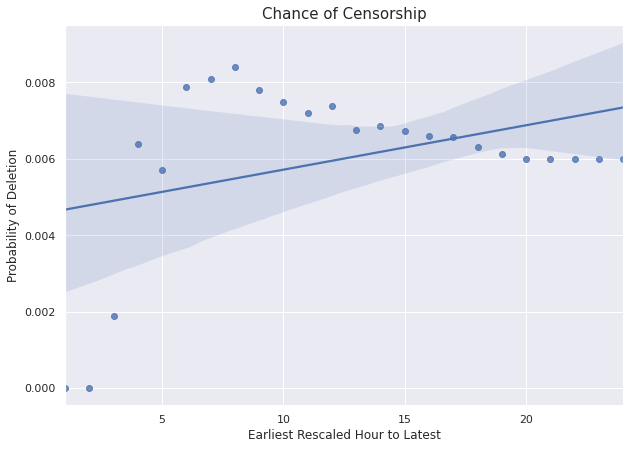

In [ ]:
import seaborn as sb

#Data
keys = list(time_status_dict.keys())
values = list(time_status_dict.values())

#Style
sb.set_style('dark')
sb.set_style('ticks')
sb.set(rc={'figure.figsize':(10, 7)})

#Create plot
plt = sb.regplot(x=keys, y=values, data=df, color = 'b')
plt.set(xlabel='Earliest Rescaled Hour to Latest', ylabel='Probability of Deletion')
plt.set_title('Chance of Censorship', fontsize=15)
plt

# 8.) Try an Easy Solution

To test the hypothesis, a Pearson's Correlation Coefficient is found. This coefficent tests whether there is a relation or independence among two variables. In the case of this test, the time of data the tweet was posted and whether it was censored or not were tested. If there is a positive correlation between the hour and the tweets status, a value near 1 should be expected.

In [ ]:
from scipy.stats import pearsonr

indices = list(time_status_dict.keys())
probability_values = list(time_status_dict.values())
table = [probability_values, indices]

#Pearson's Correlation Coefficient
stat, p = pearsonr(indices, probability_values)
print('stat=%.3f, p=%.3f' % (stat, p))

stat=0.369, p=0.076


The correlation coefficient is '0.369' and 'p', which describes whether the result is statistically significant, is 0.076.

# Write Up
Former president Donald Trump’s twitter account played an integral part in the average American’s approval toward his ability to act as commander in chief and president. Thus his tweets offer a plethora of fascinating data that can tell the story of his controversial 4 year presidency. Trump’s tweets proved so sensitive that his account was eventually suspended on the platform. This is by no surprise as his tweets seemed often not thought out, poorly worded, and incredibly unpresidential. Many of his tweets were either deleted or censored by Twitter after they violated the platform's code of conduct leading to his suspension. This begs the question as to what led Trump to believe his tweets were needed to be said and acceptable as they undoubtedly played a major role in his loss in the 2020 election. Perhaps what led to his inappropriate use of his voice as acting president was the unclear thinking that we have all experienced late at night that  has led to regrets later on.  This leads to the hypothesis that former president Donald Trump’s tweets become more controversial the later in the night they are posted. To test this, data containing whether the tweet was deleted or not and the time it was posted were needed. Using the online archive “https://www.thetrumparchive.com” which contains all 56,000 of his tweets, the needed data was scraped and placed in a dataframe. Although the data most likely contains no biases (other than Trump’s biases found in the tweets), it was important to mind my political feelings while performing the test so that my biases did not skew the data.  For the sake of this test, the last 6 months of his tweets were collected.  To accomplish the scraping, a webdriver from the python libraries selenium and requests-HTML were used to load the website and load an additional 5000 tweets. A large issue I was faced with was that the website implemented infinite scrolling thus when the website is loaded only 20 tweets are loaded into the HTML. Requests-HTML resolved this issue as it was able to request more tweets from the sites servers using javascript. A limitation of this approach is that by requesting hundreds of pages of tweets, it is possible to overload the server. Thus, the code needs to sit for 1 second between each request to prevent an overload. This causes very long run times when a large number of tweets are wanted. Another issue encountered was that Selenium was not compatible with the Google Colab environment. Fortunately, the library Kora was used which allows Selenium and other incompatible libraries to work with Colab. With these issues resolved and with tweets requested and received, the HTML of the loaded site was then pulled from the webdriver into Google Colab and was filtered using BeautifulSoup. The library BeautifulSoup was used to retrieve the elements in the HTML document containing the tweets data. In the document the tweet data were held in the tags "div class="tweet___2xXtA ttaTweet"". Each of these 5000 tags had data including time, date, text, likes, retweets, and whether it was deleted or not which was all that was necessary to perform the test.  With the data gathered, it was pulled apart and placed in a dataframe using the python library Pandas. Again using Pandas, the data was thoroughly cleaned. The text of each tweet had values “deleted” or “show” concatenated to it which were removed and placed in a new column labeled “Status.” The month of each tweet had an unnecessary number concatenated to the front so this was also removed. Following, the likes and retweet values were casted from strings to integers as they had “k” at the end of each value indicating 1000. The k was removed, the values were casted to integers, and then the values were multiplied by 1000. Lastly the columns were reindexed to create a more organized look. With the scraped and cleaned data, a visualization could finally be made. A linear regression plot and line was used comparing the hours of the day and the probability that a tweet posted at that time would be deleted. Because conventional time telling (12 am to 11:59 pm) is hard to work with when describing how late in the day a tweet was posted, the hours of the day were rescaled to be on a 24 hour scale in which the day started at 5 am and ended at 4:59 am. The linear regression visualized the level of correlation between the variables while the scatter plot showed variation between each hour. There is a clear positive correlation for the first few hours but afterwards the probability of censorship or deletion begins to decline slowly. The wide 95% confidence band of the linear regression demonstrated that the data did not really follow a trend. These results are not promising in proving the hypothesis as a complete positive relationship and narrow confidence band would be expected if the hypothesis was true. However, the visualization is not enough to prove or disprove anything. Thus, a second test was performed. Using the method “pearsonr()”  from the python library, scipy.stats, the Pearson correlation coefficient of the hour of the day and probability of a tweet being deleted at that time was found. This is calculated using the Pearson correlation coefficient formula which measures how strong a relationship is between two variables. The formula returns a number ranging from -1 to 1 with -1 demonstrating a perfect negative relationship, 0 showing independence between variables, and 1 demonstrating a perfect positive relationship. Using this equation is the most simple solution for finding a potential proof of the hypothesis as it returns a quantified, measurable number representing two variables correlation. Using this formula, the Pearson Correlation Coefficient of the variables hour and probability is 0.369. Along with the coefficient, a p value was found. The p value is a probability that the result of the coefficient is just at random and just so happens to show a correlation. If the p value is less than 0.05 (5%) than it can be concluded that the coefficient is statistically significant. The coefficient is not very close to 1 and the p-value is 0.076 demonstrating that there is no statistical significance and that the two values do not have a positive relationship. From this result, it can be concluded that the hypothesis is false.
